# Quantum Computing with Neutral Atoms

**Pulser** is an open-source software package written in Python. It provides easy-to-use libraries for designing and simulating pulse sequences that act in programmable Rydberg atom arrays.

With pulser, it is easy to define a **Register** consisting of any arrangement of atoms in a quantum processor:

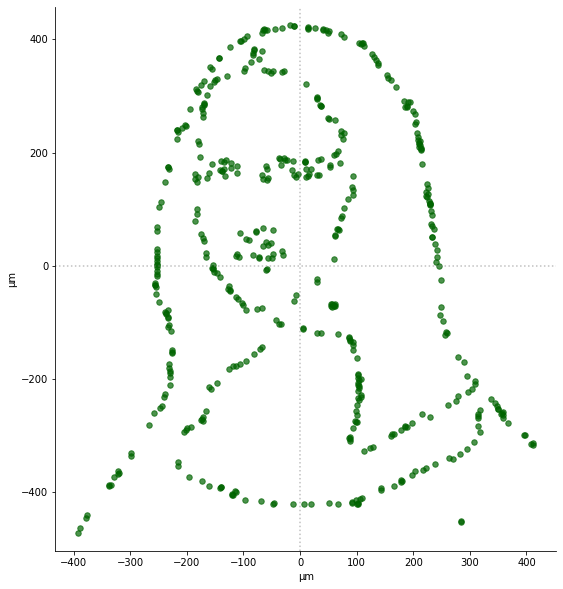

In [1]:
from pulser import Register
from pulser.devices import Chadoq2
import numpy as np

qubits = np.loadtxt("files/ml_coords")
ml_reg = Register.from_coordinates(qubits)
ml_reg.rotate(90)
ml_reg.draw(with_labels=False)

It is also simple to create and design **Pulses** that will act on the atom array:

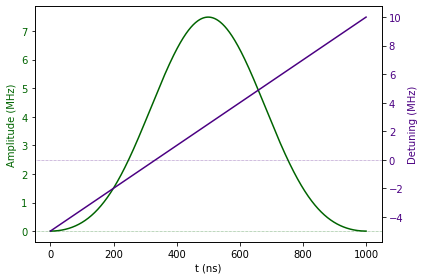

In [2]:
from pulser import Pulse
from pulser.waveforms import RampWaveform, BlackmanWaveform

duration = 1000 # Typical: ~1 µsec
pulse = Pulse(BlackmanWaveform(duration, np.pi), RampWaveform(duration, -5., 10.), 0)
pulse.draw()

Each pulse acts on a set of atoms at a certain moment of time. The entire **Sequence** is stored by Pulser and can then be either simulated or sent to a real device (such as those built by Pasqal):

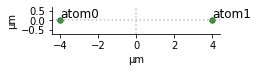

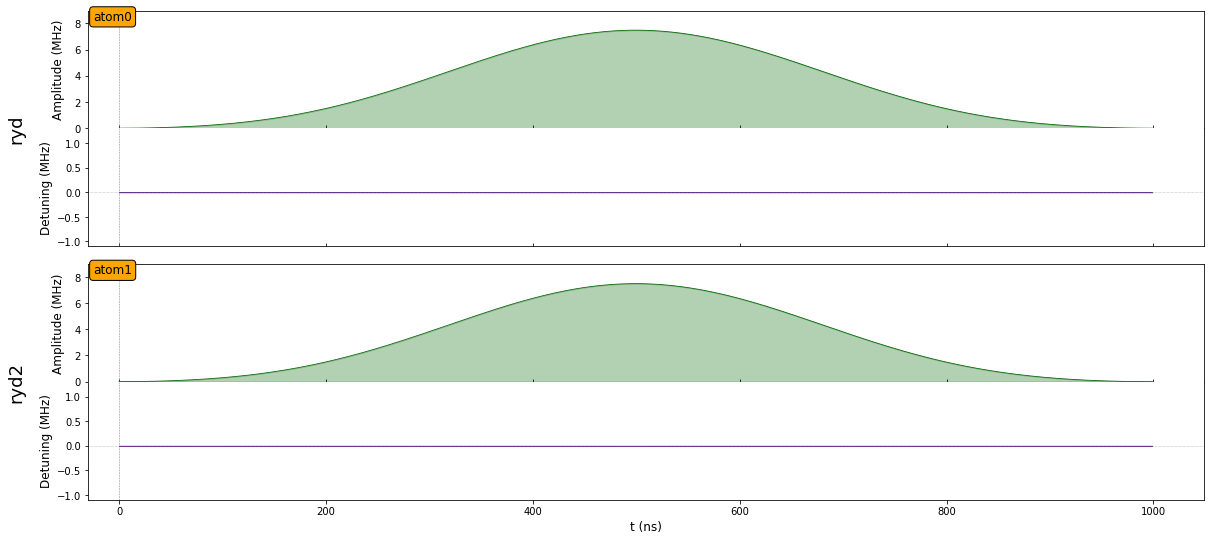

In [3]:
from pulser import Sequence

reg = Register.rectangle(1, 2, spacing=8, prefix='atom')
reg.draw()

pi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(duration, np.pi), 0., 0.)

seq = Sequence(reg, Chadoq2)

seq.declare_channel('ryd','rydberg_local','atom0')
seq.declare_channel('ryd2','rydberg_local2','atom1')

seq.add(pi_pulse,'ryd')
seq.add(pi_pulse,'ryd2')

seq.draw()

Rydberg atoms are a prominent architecture for exploring condensed matter physics and quantum information processing. For example, one can use Pulser to write a sequence of succesive $\pi$-pulses on a two atom system, each one coupling the atom to its excited Rydberg state. This will allow us to study the *Rydberg Blockade* effect, using Pulser's **Simulation** library:

The presence of the van der Waals interaction when both atoms are in the Rydberg state, prevents the collective ground state $|gg\rangle$ to couple to $|rr\rangle$, which is shifted out of resonance. 

The Hamiltonian for the two-atom system can be written as:

$$H = \frac{\hbar \Omega_1(t)}{2} \sigma_1^x + \frac{\hbar \Omega_2(t)}{2} \sigma_2^x + U n_1n_2 $$

We shall explore this blockade by changing the interatomic distance $R$:

In [4]:
import matplotlib.pyplot as plt
from pulser import Simulation

data = []
distances = np.linspace(6.5, 14, 7)

r = [1,0] # |r>
rr = np.kron(r,r) # |rr>
occup = [np.outer(rr, np.conj(rr))]  # |rr><rr|

for i,R in enumerate(distances):
    # Atom Register and Device
    reg = Register.rectangle(1,2,spacing=R, prefix='atom')

    # Pulse Sequence
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel('ryd','rydberg_local','atom0')
    seq.declare_channel('ryd2','rydberg_local2','atom1')
    seq.add(pi_pulse,'ryd')
    seq.align('ryd','ryd2')
    seq.add(pi_pulse,'ryd2')

    sim = Simulation(seq)
    
    res = sim.run()  # Returns a SimulationResults instance
    data.append(res.expect(occup)[0]) # Get expectation value for the occupation operator
print("...Simulation Complete!")

...Simulation Complete!


We plot the results

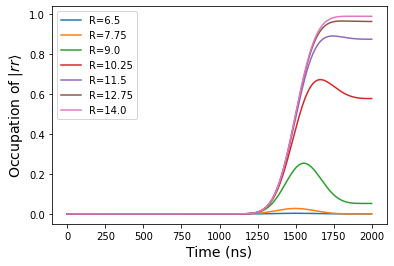

In [5]:
for i,R in enumerate(distances):
    plt.plot(data[i], label=f'R={R}')
    plt.xlabel('Time (ns)', fontsize=14)
    plt.ylabel(r'Occupation of $|rr\rangle$', fontsize=14)
    plt.legend()

Notice how the occupation of $|rr\rangle$ is suppressed for decreasing $R$. Many more details about Pulser and its features can be found in this documentation and in the Tutorials.